In [1]:
import geowombat as gw
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons

from geowombat.ml import fit
import geopandas as gpd
from sklearn_xarray.preprocessing import Featurizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

le = LabelEncoder()

# The labels are string names, so here we convert them to integers
labels = gpd.read_file(l8_224078_20200518_polygons)
labels['lc'] = le.fit(labels.name).transform(labels.name)
print(labels)

        name                                           geometry  lc
0      water  POLYGON ((737544.502 -2795232.772, 737544.502 ...   3
1       crop  POLYGON ((742517.658 -2798160.232, 743046.717 ...   0
2       tree  POLYGON ((742435.360 -2801875.403, 742458.874 ...   2
3  developed  POLYGON ((738903.667 -2811573.845, 738926.586 ...   1


In [2]:
# Use a data pipeline
pl = Pipeline([('featurizer', Featurizer()),
                ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

# Fit the classifier
with gw.config.update(ref_res=100):
    with gw.open(l8_224078_20200518, chunks=128) as src:
        X, clf = fit(src, labels, pl, col='lc')

print(clf)

Pipeline(steps=[('featurizer', Featurizer()),
                ('scaler',
                 EstimatorWrapper(copy=True, estimator=StandardScaler(),
                                  reshapes='feature', with_mean=True,
                                  with_std=True)),
                ('pca',
                 EstimatorWrapper(copy=True, estimator=PCA(),
                                  iterated_power='auto', n_components=None,
                                  random_state=None, reshapes='feature',
                                  svd_solver='auto', tol=0.0, whiten=False)),
                ('clf',
                 EstimatorWrapper(estimator=GaussianNB(), priors=None,
                                  reshapes='feature', var_smoothing=1e-09))])


<xarray.DataArray (time: 1, band: 1, y: 558, x: 612)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]]]])
Coordinates:
    targ     (time, y, x) float64 dask.array<chunksize=(1, 25, 612), meta=np.ndarray>
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.175e+05 7.176e+05 ... 7.784e+05 7.785e+05
  * time     (time) object 't1'
  * band     (band) <U4 'targ'


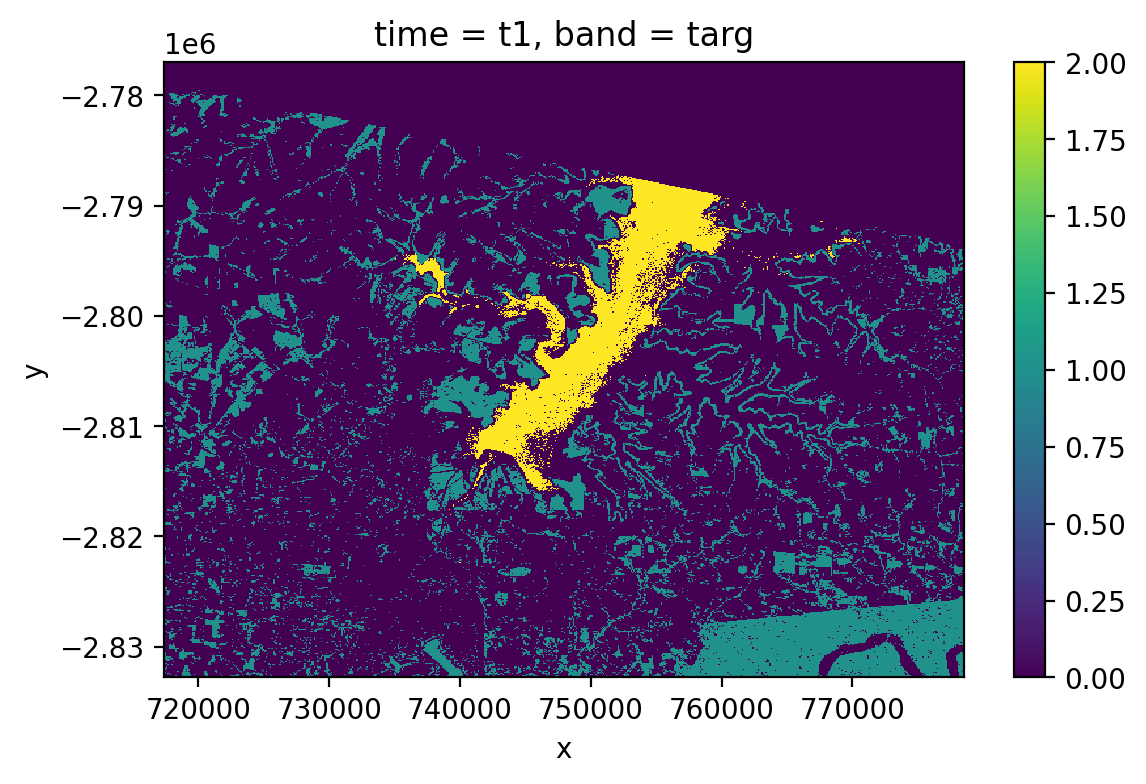

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)

from geowombat.ml import fit_predict

with gw.config.update(ref_res=100):
    with gw.open(l8_224078_20200518, chunks=128) as src:
        y = fit_predict(src, labels, pl, col='lc')
        print(y)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)
